# LAB 6 : DLQ5 — Learning to Bend a Model
> A two-layer neural network built **from scratch** using only NumPy.  
> No ML libraries. No auto-differentiation. No shortcuts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Step 1 — Create a Simple Dataset

In [2]:
# Task 1.1 — Input generation
# X: one input feature, 50 evenly-spaced samples from 0 to 10.
# This range shows both early rapid growth and later flattening —
# a shape a linear model cannot fit with a single slope.
X = np.linspace(0, 10, 50).reshape(-1, 1)   # shape: (50, 1)
print("X shape:", X.shape)

X shape: (50, 1)


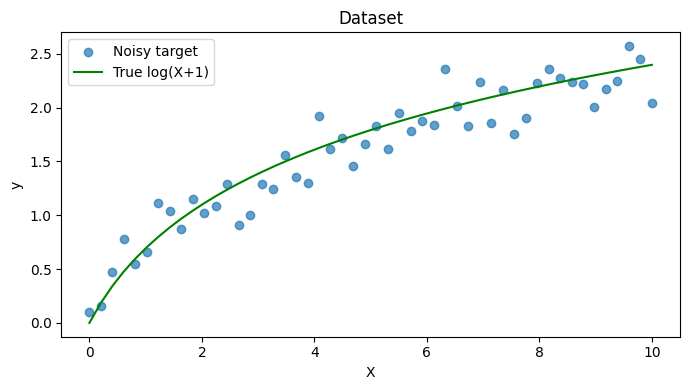

In [3]:
# Task 1.2 — Target generation
# y = log(X + 1) + small noise.
# A straight line cannot fit this because log grows fast early and
# nearly plateaus later — one slope can't win both regions.
np.random.seed(42)
noise = np.random.normal(0, 0.2, size=(50, 1))  # small, not dominating
y = np.log(X + 1) + noise

plt.figure(figsize=(7, 4))
plt.scatter(X, y, alpha=0.7, label="Noisy target")
plt.plot(X, np.log(X + 1), color='green', label="True log(X+1)")
plt.title("Dataset")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

## Step 2 — Decide the Model Shape

**Hidden units chosen: 3**
- *Why more than 1?* Multiple units combine several piece-wise curves into a richer shape.
- *Why not too many?* More units increase complexity, slow training, and risk instability on 50 samples.

We are fixing the **architecture**, not yet tuning numbers.

## Step 3 — Initialize Model Parameters

In [4]:
input_size  = 1   # one feature
hidden_size = 3   # three hidden units
output_size = 1   # one scalar prediction

# W1 — controls how the input is transformed into each hidden unit (shape/bending)
# b1 — shifts each hidden unit's activation threshold (position)
W1 = np.random.uniform(-1, 1, size=(input_size,  hidden_size))  # (1, 3)
b1 = np.zeros((1, hidden_size))                                  # (1, 3)

# W2 — combines hidden signals into the output (output shape)
# b2 — shifts the final output up or down (vertical position)
W2 = np.random.uniform(-1, 1, size=(hidden_size, output_size))  # (3, 1)
b2 = np.zeros((1, output_size))                                  # (1, 1)

print("W1:", W1.shape, "b1:", b1.shape)
print("W2:", W2.shape, "b2:", b2.shape)

W1: (1, 3) b1: (1, 3)
W2: (3, 1) b2: (1, 1)


## Step 4 — Activation Function (ReLU)

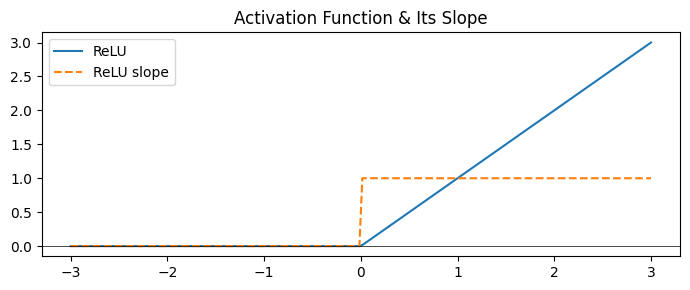

In [5]:
def activation(z):
    """ReLU: keeps positive values, suppresses (zeroes) negative values.
    This is the non-linearity that lets the network bend its predictions."""
    return np.maximum(0, z)

def activation_slope(z):
    """Derivative of ReLU: 1 where z > 0, else 0.
    The slope matters because it tells the gradient how much a change
    in z affects the loss — without it there is no learning signal."""
    return (z > 0).astype(float)

# Quick visual check
z_test = np.linspace(-3, 3, 200)
plt.figure(figsize=(7, 3))
plt.plot(z_test, activation(z_test), label="ReLU")
plt.plot(z_test, activation_slope(z_test), label="ReLU slope", linestyle='--')
plt.axhline(0, color='k', linewidth=0.5)
plt.title("Activation Function & Its Slope")
plt.legend()
plt.tight_layout()
plt.show()

## Steps 5–9 inside the Training Loop

| Step | What happens |
|------|--------------|
| 5 | **Forward pass** — compute z1, h, y_hat |
| 6 | **Loss** — MSE between y_hat and y |
| 8 | **Backward pass** — chain rule through each layer |
| 9 | **Update** — subtract learning_rate × gradient |

In [6]:
# Hyperparameters
# learning_rate = 0.01 — small enough to avoid overshooting the minimum
# epochs = 2000        — enough for loss to plateau on this 50-sample dataset
learning_rate = 0.01
epochs        = 2000

loss_history = []

for epoch in range(epochs):

    # ── STEP 5: Forward Pass ──────────────────────────────────────────
    z1    = X @ W1 + b1          # linear: z1 = X·W1 + b1   shape (50,3)
    h     = activation(z1)       # non-linear bend            shape (50,3)
    y_hat = h @ W2 + b2          # output: y_hat = h·W2 + b2 shape (50,1)

    # ── STEP 6: Error & Loss ──────────────────────────────────────────
    error = y_hat - y            # signed per-sample error
    # MSE — squaring amplifies large mistakes, forcing aggressive correction
    loss  = np.mean(error ** 2)
    loss_history.append(loss)

    # ── STEP 8: Backward Pass (manual chain rule) ─────────────────────

    # 8.1 — dL/dy_hat = 2*(y_hat - y)/N
    dL_dy  = 2 * error / len(X)

    # 8.2 — Output layer gradients
    # dL/dW2 depends on h because W2 multiplies h in the forward pass
    dL_dW2 = h.T @ dL_dy
    dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)

    # 8.3 — Push gradient back through W2 into hidden layer
    dL_dh  = dL_dy @ W2.T

    # 8.4 — Gate by ReLU slope; dead neurons (z<=0) receive zero gradient
    # This is how activation controls error flow through the network
    dL_dz1 = dL_dh * activation_slope(z1)

    # 8.5 — First layer gradients
    dL_dW1 = X.T @ dL_dz1
    dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

    # ── STEP 9: Update  θ := θ − η·(dL/dθ) ──────────────────────────
    # Like the perceptron rule: move opposite to the error gradient
    W1 -= learning_rate * dL_dW1
    b1 -= learning_rate * dL_db1
    W2 -= learning_rate * dL_dW2
    b2 -= learning_rate * dL_db2

    if epoch % 200 == 0:
        print(f"Epoch {epoch:5d} | Loss: {loss:.6f}")

print(f"\nFinal Loss: {loss:.6f}")

Epoch     0 | Loss: 0.216705
Epoch   200 | Loss: 0.061057
Epoch   400 | Loss: 0.052120
Epoch   600 | Loss: 0.051148
Epoch   800 | Loss: 0.051038
Epoch  1000 | Loss: 0.051026
Epoch  1200 | Loss: 0.051024
Epoch  1400 | Loss: 0.051024
Epoch  1600 | Loss: 0.051024
Epoch  1800 | Loss: 0.051024

Final Loss: 0.051024


## Results

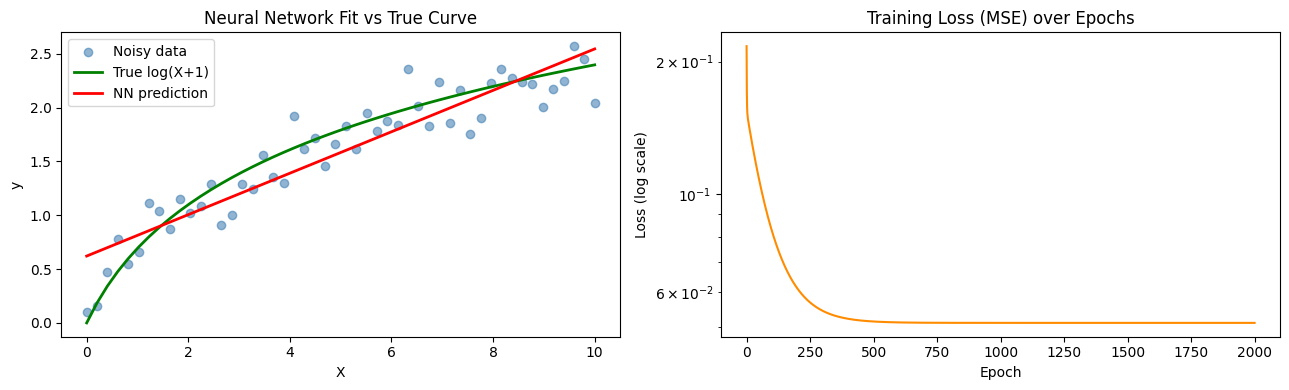

In [7]:
# Final forward pass
y_hat_final = activation(X @ W1 + b1) @ W2 + b2

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Plot 1: Predictions vs true curve
axes[0].scatter(X, y, alpha=0.6, color='steelblue', label='Noisy data')
axes[0].plot(X, np.log(X + 1), color='green', linewidth=2, label='True log(X+1)')
axes[0].plot(X, y_hat_final,   color='red',   linewidth=2, label='NN prediction')
axes[0].set_title('Neural Network Fit vs True Curve')
axes[0].set_xlabel('X')
axes[0].set_ylabel('y')
axes[0].legend()

# Plot 2: Training loss
axes[1].plot(loss_history, color='darkorange')
axes[1].set_yscale('log')
axes[1].set_title('Training Loss (MSE) over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (log scale)')

plt.tight_layout()
plt.show()